In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')    
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Let's have a look at the profile report of our data to know more about it and have better insights. 

In [4]:
import pandas_profiling as pp
pp.ProfileReport(data)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


From the profile report it can be concluded that we have 3 columns with **missing values i.e. Age, Cabin and Embarked**. 

Plotting the histogram of all variables to check their structures.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7a8fa95c0>,
      dtype=object)

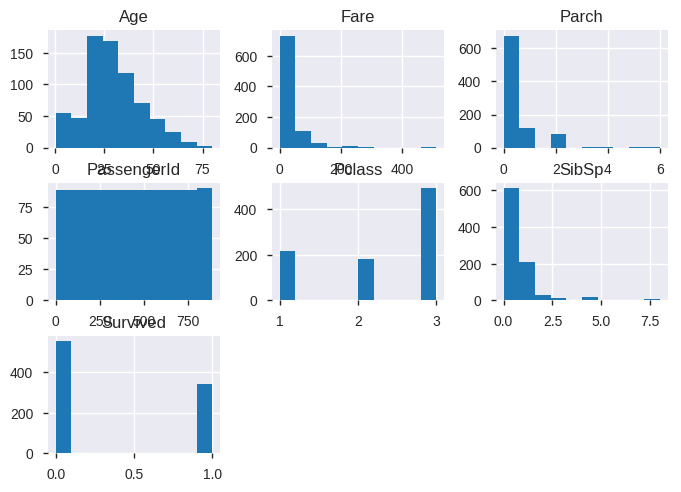

In [5]:
data.hist()

It can be seen that Age is in normalized form so the missing values of **Age** column can be fixed with the mean, also the features Parch and SibSp which says the number of parents and siblings can be merged together to form a new feature **family**. The family will tell about the family members present on the ship and what was it's consequence on survival rates. The Parch and SibSp columns can now be dropped.

The PassengerId is unique for all passengers and hence will not contribute to any insights. The column is dropped for memory optimization.

In [6]:
data['family'] = data['Parch'] + data['SibSp']
data.drop(['Parch','SibSp'], axis = 1, inplace = True)
data.drop(['PassengerId'], axis=1, inplace = True)


#repeating porcess for testing data
test_data['family'] = test_data['Parch'] + test_data['SibSp']
test_data.drop(['Parch','SibSp'], axis = 1, inplace = True)

**We will now replace all the missing values in the rows.**

* The missing values in the **Age** column will be replaced by the mean of the values (since the ages are in normalised form that implies less number or no presence of outliers in the data, hence mean will be a favorable method to tranform the columns). 
* The **Embarked** column contains the categorical data, hence it will be suitable to replace the missing values with the mode. 
* Lastly, **Cabin** column also contains categorical data, and in ships it is only the upper class which is provided with cabins, so for the rest of the data we will assign cabin as 'Z' (any random category). Also, since the cabin column has high cardinality we will group then to classes as {A, B, C, D,....}. 

In [7]:
#Converting all nan values to string since the numpy function will only works with String or numerical values
data.Embarked = data.Embarked.fillna('X')
#Checking the most frequent class in Embarked column
print(np.unique(data.Embarked, return_counts=True))

#Testing data
test_data.Embarked = test_data.Embarked.fillna('X')

(array(['C', 'Q', 'S', 'X'], dtype=object), array([168,  77, 644,   2]))


In [8]:
import re
data.Age = data.Age.fillna(np.mean(data.Age))

#Since S have the highest frequency in Embarked
data.Embarked = data.Embarked.str.replace('X','S')
data.Cabin = data.Cabin.fillna('Z')

def classify_cabin(cabin):
    cabin = list(cabin)
    for i in range(len(cabin)):
        cabin[i] = re.findall(r'\w', cabin[i])[0]
    return list(cabin)

data.Cabin = classify_cabin(data.Cabin)

#testing data
test_data.Age = test_data.Age.fillna(np.mean(test_data.Age))
test_data.Embarked = test_data.Embarked.str.replace('X','S')
test_data.Cabin = test_data.Cabin.fillna('Z')
test_data.Cabin = classify_cabin(test_data.Cabin)

In [9]:
np.unique(data.Embarked, return_counts=True) 

(array(['C', 'Q', 'S'], dtype=object), array([168,  77, 646]))

Now let's have a look at the data after filling all the missing values.

In [10]:
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,Z,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,Z,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,Z,S,0


In [11]:
data.tail()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
886,0,2,"Montvila, Rev. Juozas",male,27.000000,211536,13.00,Z,S,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,112053,30.00,B,S,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,W./C. 6607,23.45,Z,S,3
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,111369,30.00,C,C,0
890,0,3,"Dooley, Mr. Patrick",male,32.000000,370376,7.75,Z,Q,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       891 non-null object
Embarked    891 non-null object
family      891 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


After having a look at the dataset it can be concluded that data is free from any missing values. Further we will check the features about how they can be modified to give useful information about data. 

Let's check the **relation between ticket number and other variables** associated. This is done to check the associativity in other variables if ticket number is same for two passengers, since it have high cardinality associated with it.

In [13]:
data.Ticket.value_counts()

CA. 2343             7
347082               7
1601                 7
347088               6
CA 2144              6
3101295              6
S.O.C. 14879         5
382652               5
17421                4
W./C. 6608           4
347077               4
113781               4
PC 17757             4
LINE                 4
19950                4
2666                 4
113760               4
4133                 4
349909               4
24160                3
230080               3
110152               3
345773               3
C.A. 31921           3
PC 17582             3
363291               3
C.A. 34651           3
239853               3
347742               3
248727               3
                    ..
13214                1
374910               1
3101296              1
345779               1
113503               1
370373               1
113501               1
243880               1
382649               1
C.A. 29566           1
315098               1
W/C 14208            1
16988      

Let's check the values of other features based on the ticket number. We will see some random tickets and their corresponding values.

In [14]:
data[data["Ticket"]=="1601"]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
74,1,3,"Bing, Mr. Lee",male,32.000000,1601,56.4958,Z,S,0
169,0,3,"Ling, Mr. Lee",male,28.000000,1601,56.4958,Z,S,0
509,1,3,"Lang, Mr. Fang",male,26.000000,1601,56.4958,Z,S,0
643,1,3,"Foo, Mr. Choong",male,29.699118,1601,56.4958,Z,S,0
692,1,3,"Lam, Mr. Ali",male,29.699118,1601,56.4958,Z,S,0
826,0,3,"Lam, Mr. Len",male,29.699118,1601,56.4958,Z,S,0
838,1,3,"Chip, Mr. Chang",male,32.000000,1601,56.4958,Z,S,0


In [15]:
data[data["Ticket"]=="PC 17755"]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
258,1,1,"Ward, Miss. Anna",female,35.0,PC 17755,512.3292,Z,C,0
679,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,PC 17755,512.3292,B,C,1
737,1,1,"Lesurer, Mr. Gustave J",male,35.0,PC 17755,512.3292,B,C,0


In [16]:
data[data['Ticket']=='S.O.C. 14879']

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
72,0,2,"Hood, Mr. Ambrose Jr",male,21.0,S.O.C. 14879,73.5,Z,S,0
120,0,2,"Hickman, Mr. Stanley George",male,21.0,S.O.C. 14879,73.5,Z,S,2
385,0,2,"Davies, Mr. Charles Henry",male,18.0,S.O.C. 14879,73.5,Z,S,0
655,0,2,"Hickman, Mr. Leonard Mark",male,24.0,S.O.C. 14879,73.5,Z,S,2
665,0,2,"Hickman, Mr. Lewis",male,32.0,S.O.C. 14879,73.5,Z,S,2


These results clearly shows that the passengers with same ticket number also have same fare, class, and place of boarding(Embarked). The column Ticket can be dropped, since the insights it give can also be found by Fare cabin. Ticket feature seems anologous to the Fare feature and they give same insights about data.

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
family         418 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 32.7+ KB


Filling the null value in test data

In [18]:
test_data[np.isnan(test_data['Fare'])]

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family
152,1044,3,"Storey, Mr. Thomas",male,60.5,3701,NaN,Z,S,0


In [19]:
group = test_data.groupby(['Embarked', 'Pclass']).mean()
group

PassengerId        Age        Fare    family
Embarked Pclass                                              
C        1       1095.196429  40.116878  110.073511  0.875000
         2       1114.363636  26.049562   20.120445  0.636364
         3       1087.657143  26.310327   10.658700  0.742857
Q        1       1303.000000  37.000000   90.000000  1.000000
         2        965.750000  47.068148   11.273950  0.000000
         3       1094.951220  27.957795    8.998985  0.219512
S        1       1097.520000  39.978163   76.677504  0.840000
         2       1126.243590  28.320066   23.056090  0.769231
         3       1095.563380  25.497010   13.913030  1.105634

In [20]:
for i in range(test_data.shape[0]):
    if np.isnan(test_data['Fare'][i]):
        test_data['Fare'][i] = 13.913030

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
data.drop(['Ticket'], axis=1, inplace=True)

#Testing data
test_data.drop(['Ticket'], axis=1, inplace=True)

* The Class and Embarked column might give some valueable insights about the survival rates. It might be possible that upper class have high probability of survival, also the people boarding from different places may have different survival rates. We will have a look at this relation further in our insights.

* There might also be differences on the basis of cabin and sex on survival rates. 

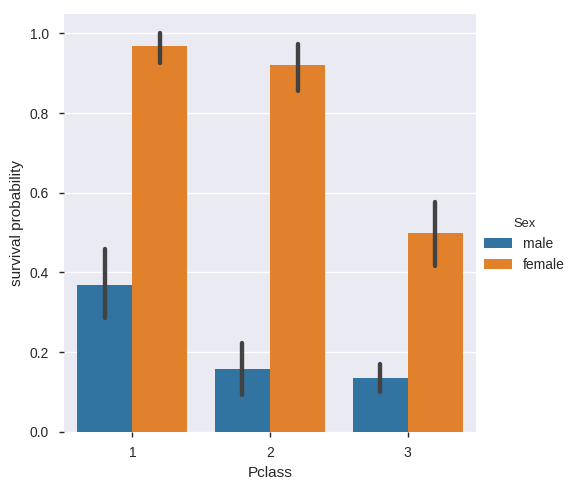

In [22]:
import seaborn as sns
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=data, kind="bar")
g.set_ylabels("survival probability")

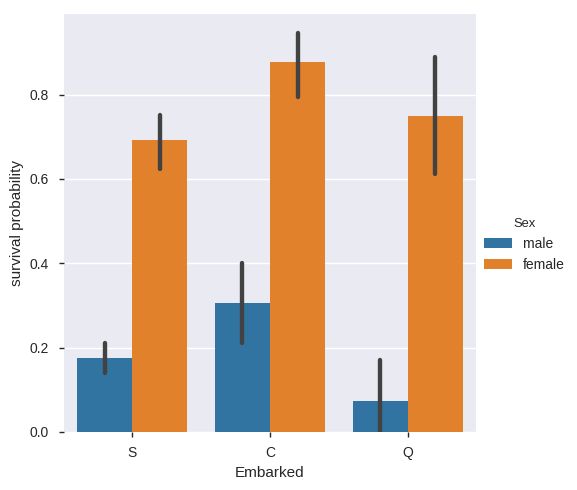

In [23]:
h = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=data, kind="bar")
h.set_ylabels("survival probability")

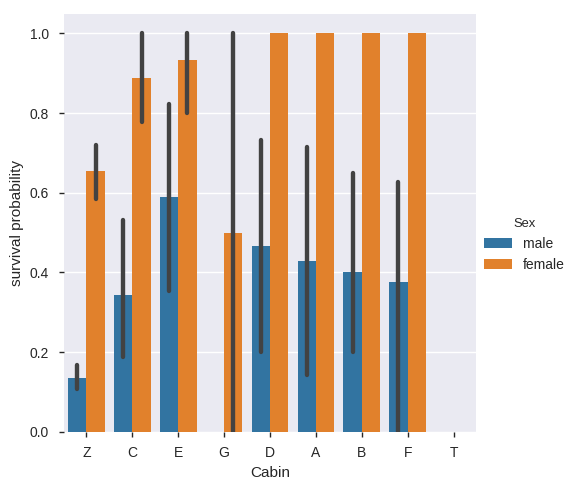

In [24]:
h = sns.catplot(x="Cabin", y="Survived", hue="Sex", data=data, kind="bar")
h.set_ylabels("survival probability")

Now further changes can be done with categorical features to convert them to numerical form.

* We will use Label encoding for converting Pclass, Cabin, Embarked columns since they seems ordinal categorical data giving higher priority to categories with large survival rates. 
* Also for Sex column we will use Label encoding since from all these 3 plots we can conclude that females have high chances of survival rether males. 

Here, we will not be using the predefined LabelEncoder from Scikit Learn library instead will solve it using logics. This is done so that categorical features be encoded according to the priority we choose. 


In [25]:
#label encoding for Sex
data['Sex'] = data['Sex'].astype('category')
data['Sex'] = data['Sex'].cat.reorder_categories(['female', 'male'], ordered=True)
data['Sex'] = data['Sex'].cat.codes

#label encoding for Pclass
data['Pclass'] = data['Pclass'].astype('category')
data['Pclass'] = data['Pclass'].cat.reorder_categories([1, 2, 3], ordered=True)
data['Pclass'] = data['Pclass'].cat.codes

#label encoding for Embarked
data['Embarked'] = data['Embarked'].astype('category')
data['Embarked'] = data['Embarked'].cat.reorder_categories(['C', 'Q', 'S'], ordered=True)
data['Embarked'] = data['Embarked'].cat.codes

#label encoding for Cabin
data['Cabin'] = data['Cabin'].astype('category')
data['Cabin'] = data['Cabin'].cat.reorder_categories(['D', 'A', 'B', 'F', 'E', 'C', 'Z', 'G', 'T'], ordered=True)
data['Cabin'] = data['Cabin'].cat.codes

#Testing data

#label encoding for Sex
test_data['Sex'] = test_data['Sex'].astype('category')
test_data['Sex'] = test_data['Sex'].cat.reorder_categories(['female', 'male'], ordered=True)
test_data['Sex'] = test_data['Sex'].cat.codes

#label encoding for Pclass
test_data['Pclass'] = test_data['Pclass'].astype('category')
test_data['Pclass'] = test_data['Pclass'].cat.reorder_categories([1, 2, 3], ordered=True)
test_data['Pclass'] = test_data['Pclass'].cat.codes

#label encoding for Embarked
test_data['Embarked'] = test_data['Embarked'].astype('category')
test_data['Embarked'] = test_data['Embarked'].cat.reorder_categories(['C', 'Q', 'S'], ordered=True)
test_data['Embarked'] = test_data['Embarked'].cat.codes

#label encoding for Cabin
test_data['Cabin'] = test_data['Cabin'].astype('category')
test_data['Cabin'] = test_data['Cabin'].cat.reorder_categories(['D', 'A', 'B', 'F', 'E', 'C', 'Z', 'G'], ordered=True)
test_data['Cabin'] = test_data['Cabin'].cat.codes

In [26]:
#Let's now have a look at our data
data.head()

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,family
0,0,2,"Braund, Mr. Owen Harris",1,22.0,7.2500,6,2,1
1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,71.2833,5,0,1
2,1,2,"Heikkinen, Miss. Laina",0,26.0,7.9250,6,2,0
3,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,53.1000,5,2,1
4,0,2,"Allen, Mr. William Henry",1,35.0,8.0500,6,2,0


We will drop the column Name as the relation between the age, gender and their category of belonging to the upper caste can be figured out from other feature, the work which is probably done by their titles is replaced by other features.  

In [27]:
data.drop(["Name"], axis=1, inplace=True)

#Testing data
test_data.drop(["Name"], axis=1, inplace=True)

In [28]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family
0,0,2,1,22.0,7.2500,6,2,1
1,1,0,0,38.0,71.2833,5,0,1
2,1,2,0,26.0,7.9250,6,2,0
3,1,0,0,35.0,53.1000,5,2,1
4,0,2,1,35.0,8.0500,6,2,0


Our data is now ready to be scaled and trained on a model

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(data))
scaled.columns = data.columns
train = scaled.drop(['Survived'], axis=1)
test = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(train,test, random_state=42)



Since this is a binary classification, we will use Logistic Regression for preparing our model

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 0, solver='liblinear').fit(X_train, y_train)
pred = clf.predict(X_test)

Let's have a look at the predctions by our model through confusion_matrix

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[113,  21],
       [ 21,  68]])

The various scores

In [32]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Accuracy Score %f" %accuracy_score(y_test, pred))
print("Precision Score %f" %precision_score(y_test, pred))
print("Recall Score %f" %recall_score(y_test, pred))

Accuracy Score 0.811659
Precision Score 0.764045
Recall Score 0.764045


Predicting the values for our test data

In [33]:
test_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,family
0,892,2,1,34.5,7.8292,6,1,0
1,893,2,0,47.0,7.0000,6,2,1
2,894,1,1,62.0,9.6875,6,1,0
3,895,2,1,27.0,8.6625,6,2,0
4,896,2,0,22.0,12.2875,6,2,2


In [34]:
scaled_test = pd.DataFrame(scaler.fit_transform(test_data.drop(['PassengerId'], axis=1)))
scaled_test.columns = test_data.drop(['PassengerId'], axis=1).columns
scaled_test.head()


,Pclass,Sex,Age,Fare,Cabin,Embarked,family
0,0.873482,0.755929,0.334993,-0.497386,0.422715,-0.470915,-0.553443
1,0.873482,-1.322876,1.325530,-0.512250,0.422715,0.700767,0.105643
2,-0.315819,0.755929,2.514175,-0.464073,0.422715,-0.470915,-0.553443
3,0.873482,0.755929,-0.259330,-0.482448,0.422715,0.700767,-0.553443
4,0.873482,-1.322876,-0.655545,-0.417465,0.422715,0.700767,0.764728


In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int8
Sex            418 non-null int8
Age            418 non-null float64
Fare           418 non-null float64
Cabin          418 non-null int8
Embarked       418 non-null int8
family         418 non-null int64
dtypes: float64(2), int64(2), int8(4)
memory usage: 14.8 KB


In [36]:
test_predict = clf.predict(scaled_test)
submission_format = pd.read_csv('../input/gender_submission.csv')
submission_format.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = test_predict
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [38]:
#submission.to_csv('LogisticRegressionClassification.csv', index = False)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 12)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
confusion_matrix(y_test, pred)

array([[116,  18],
       [ 21,  68]])

In [40]:
print("Accuracy Score %f" %accuracy_score(y_test, pred))
print("Precision Score %f" %precision_score(y_test, pred))
print("Recall Score %f" %recall_score(y_test, pred))

Accuracy Score 0.825112
Precision Score 0.790698
Recall Score 0.764045


In [41]:
test_predict = neigh.predict(scaled_test)
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = test_predict
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [42]:
submission.to_csv('SurvivalOnTitanicPrediction.csv', index = False)